In [22]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, accuracy_score, plot_roc_curve, plot_confusion_matrix, roc_curve, confusion_matrix
import itertools
from tensorflow.keras.initializers import Constant, TruncatedNormal
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from numpy import mean, absolute

# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

Balance Out Dataset

In [23]:
infile = open('../01_prognosemodell/06_newtry/fairness_ready.pkl','rb')
df = pickle.load(infile)
infile.close()

df_demo = df[['UebungsID','AbiEltern']]
df_demo = df_demo.drop_duplicates()

In [24]:
n = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]

for i in n:
    path='../01_prognosemodell/06_newtry/matrices_allsessions/matrix'+str(i)+'.pkl'
    infile = open(path,'rb')
    df = pickle.load(infile)
    infile.close()
    df = df.reset_index(level=0)
    df = pd.merge(df, df_demo, how='left', on='UebungsID')

    df.AbiEltern = df.AbiEltern.astype('float')
    df['AbiEltern'] = df['AbiEltern'].replace([2],1)
    
    ## Undersampling
    df_1 = df[df.AbiEltern==1]
    df_0 = df[df.AbiEltern==0]
    # if(len(df_1) > len(df_0)):
    #     n = len(df_0)
    #     df_1 = df_1.sample(n=n)
    # else:
    #     n = len(df_1)
    #     df_0 = df_0.sample(n=n)
    df = pd.concat([df_0,df_1])    

    # Randomly over sample the minority class
    X_df = df.drop(columns=['AbiEltern'])
    y_df = df.AbiEltern
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote= smote.fit_resample(X_df, y_df)
    df = X_train_smote.join(pd.DataFrame(list(y_train_smote.values), columns=['AbiEltern']))
    
    path = 'AbiEltern_allsessions/matrix'+ str(i) +'.pkl'
    df.to_pickle(path)

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\3931807376.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentence_len = sentence_len.append({'Sentence': x, 'Count':l}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\3931807376.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentence_len = sentence_len.append({'Sentence': x, 'Count':l}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\3931807376.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentence_len = sentence_len.append({'Sentence': x, 'Count':l}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\3931807376.py:10: FutureWarning: The frame.append method is deprecated and will be remo

<AxesSubplot:xlabel='Sentence', ylabel='Count'>

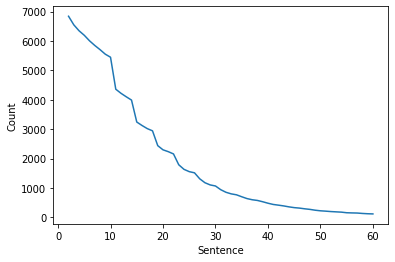

In [25]:
n = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
sentence_len= pd.DataFrame(columns=['Sentence', 'Count'])

for x in n:
    path='AbiEltern_allsessions/matrix'+str(x)+'.pkl'
    infile = open(path,'rb')
    get_length = pickle.load(infile)
    infile.close()
    l = len(get_length)
    sentence_len = sentence_len.append({'Sentence': x, 'Count':l}, ignore_index=True)

sentence_len['Sentence']=sentence_len['Sentence'].astype('int')
sentence_len['Count']=sentence_len['Count'].astype('int')
sns.lineplot(data=sentence_len, x="Sentence", y="Count")

Models

In [26]:
metrics = pd.DataFrame(columns=['model', 'group', 'subgroup','Length', 'Sentence', 'Accuracy', 'Precision', 'Recall', 'AUC', 'FPR'])

In [27]:
def get_metrics(clf,X,y,cv,pred):
    a = accuracy_score(y,pred)
    p = precision_score(y,pred)
    r = recall_score(y,pred)
    roc_auc = roc_auc_score(y,pred)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    fpr = fp/(fp+tn)

    return a,p,r,roc_auc,fpr

In [28]:
n = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
feature_cols = ['Erstloesung','Schussel','Erfolg', 'Schwierigkeit', 'ist_Schulzeit', 'MehrfachFalsch', 'vorher_abgebrochen','Fehler', 'Klassenstufe', 'Jahredabei', 'AnzahlAufgaben', 'Sex__m', 'Sex__w', 'Testposition__pruefung', 'Testposition__training','Testposition__version', 'Art__GK', 'Art__GR', 'Art__GZ', 'Art__K', 'Art__LB','UserAttribut', 'OrderNumber', 'steps']

for i in n:
    #build models
    path='AbiEltern_allsessions/matrix'+str(i)+'.pkl'
    infile = open(path,'rb')
    df = pickle.load(infile)
    infile.close()
    df=df.reset_index()
    X = df[feature_cols]
    y = df.y
    y= y.astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    k = 5
    cv = KFold(n_splits=k, random_state=None)

    #DTE
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    clf = clf.fit(X_train,y_train)
    pred = clf.predict(X_test)

    a,p,r,roc_auc,fpr = get_metrics(clf,X_test,y_test,cv,pred)

    metrics = metrics.append({'model':'DTE','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

    group = ['abiEltern', 'abiEltern']
    subgroup = ['abi', 'keinAbi']
    matrice = ['matrices_forte_abi', 'matrices_forte_keinAbi']

    for (group, subgroup, matrix) in zip(group, subgroup, matrice):
        path= '../01_prognosemodell/06_newtry/'+matrix+'/matrix'+str(i)+'.pkl'
        infile = open(path,'rb')
        df = pickle.load(infile)
        infile.close()
        df=df.reset_index()
        X = df[feature_cols]
        y = df.y
        y= y.astype('int')
        pred = clf.predict(X)
        
        a,p,r,roc_auc,fpr = get_metrics(clf,X,y,cv,pred)
        metrics = metrics.append({'model':'DTE','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\3654491290.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DTE','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\3654491290.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DTE','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\3654491290.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  me

In [29]:
n =  [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
feature_cols = ['Erstloesung','Schussel','Erfolg', 'Schwierigkeit', 'ist_Schulzeit', 'MehrfachFalsch', 'vorher_abgebrochen','Fehler', 'Klassenstufe', 'Jahredabei', 'AnzahlAufgaben', 'Sex__m', 'Sex__w', 'Testposition__pruefung', 'Testposition__training','Testposition__version', 'Art__GK', 'Art__GR', 'Art__GZ', 'Art__K', 'Art__LB','UserAttribut', 'OrderNumber', 'steps']

for i in n:
    #build models
    path='AbiEltern_allsessions/matrix'+str(i)+'.pkl'
    infile = open(path,'rb')
    df = pickle.load(infile)
    infile.close()
    df=df.reset_index()
    X = df[feature_cols]
    y = df.y
    y= y.astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    k = 5
    cv = KFold(n_splits=k, random_state=None)

    #knn
    knn = KNeighborsClassifier(n_neighbors=15)##geändert zum test
    knn = knn.fit(X_train, y_train)

    pred = knn.predict(X_test)
    a,p,r,roc_auc,fpr = get_metrics(knn,X_test,y_test,cv,pred)
    metrics = metrics.append({'model':'KNN','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

    group = ['abiEltern', 'abiEltern']
    subgroup = ['abi', 'keinAbi']
    matrice = ['matrices_forte_abi', 'matrices_forte_keinAbi']
    
    for (group, subgroup, matrix) in zip(group, subgroup, matrice):
        path= '../01_prognosemodell/06_newtry/'+matrix+'/matrix'+str(i)+'.pkl'
        infile = open(path,'rb')
        df = pickle.load(infile)
        infile.close()
        df=df.reset_index()
        X = df[feature_cols]
        y = df.y
        y= y.astype('int')
        pred = knn.predict(X)

        a,p,r,roc_auc,fpr = get_metrics(knn,X,y,cv,pred)
        metrics = metrics.append({'model':'KNN','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\511260884.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'KNN','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\511260884.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'KNN','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\511260884.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metri

In [30]:
# baseline model
def build_model():
	# create model
	model = Sequential()
	model.add(Dense(24, input_dim=24, activation='relu'))
	model.add(Dense(48, activation='relu'))
	model.add(Dense(24, activation='relu'))
	model.add(Dense(12, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
		
	return model


def get_dn_metrics(model, X,y):
    yhat_probs = model.predict(X, verbose=0)
    yhat_classes =  (model.predict(X) > 0.5).astype("int32")
    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]
    a = accuracy_score(y, yhat_classes)
    p = precision_score(y, yhat_classes)
    r = recall_score(y, yhat_classes)
    roc_auc = roc_auc_score(y, yhat_probs)
    tn, fp, fn, tp = confusion_matrix(y, yhat_classes).ravel()
    fpr = fp/(fp+tn)

    return a,p,r,roc_auc,fpr

n =  [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
feature_cols = ['Erstloesung','Schussel','Erfolg', 'Schwierigkeit', 'ist_Schulzeit', 'MehrfachFalsch', 'vorher_abgebrochen','Fehler', 'Klassenstufe', 'Jahredabei', 'AnzahlAufgaben', 'Sex__m', 'Sex__w', 'Testposition__pruefung', 'Testposition__training','Testposition__version', 'Art__GK', 'Art__GR', 'Art__GZ', 'Art__K', 'Art__LB','UserAttribut', 'OrderNumber', 'steps']

for i in n:
    path='AbiEltern_allsessions/matrix'+str(i)+'.pkl'
    infile = open(path,'rb')
    df = pickle.load(infile)
    infile.close()
    df=df.reset_index()

    y_len = len(feature_cols)
    X = df[feature_cols].astype(float)
    y = df.y
    y= y.astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    model = build_model()

    model.compile(
        loss="binary_crossentropy",
        optimizer='Adam',
        metrics=["accuracy"]
    )

    model.fit(
        x=X_train,
        y=y_train,
        epochs=10,
        batch_size=128,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    scores = model.evaluate(
        x=X_test,
        y=y_test,
        verbose=0
    )

    a,p,r,roc_auc,fpr= get_dn_metrics(model, X_test,y_test)
    metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

    group = ['abiEltern', 'abiEltern']
    subgroup = ['abi', 'keinAbi']
    matrice = ['matrices_forte_abi', 'matrices_forte_keinAbi']

    for (group, subgroup, matrix) in zip(group, subgroup, matrice):
        path= '../01_prognosemodell/06_newtry/'+matrix+'/matrix'+str(i)+'.pkl'
        infile = open(path,'rb')
        df = pickle.load(infile)
        infile.close()
        df=df.reset_index()
        y_len = len(feature_cols)
        X = df[feature_cols].astype(float)
        y = df.y
        y= y.astype('int')

        a,p,r,roc_auc,fpr= get_dn_metrics(model, X,y)

        metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

65/65 [==============================] - 0s 865us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


696/696 [==============================] - 1s 831us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


252/252 [==============================] - 0s 842us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


62/62 [==============================] - 0s 830us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


687/687 [==============================] - 1s 860us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


249/249 [==============================] - 0s 848us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


60/60 [==============================] - 0s 803us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


682/682 [==============================] - 1s 846us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


248/248 [==============================] - 0s 827us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


59/59 [==============================] - 0s 839us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


677/677 [==============================] - 1s 821us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


245/245 [==============================] - 0s 851us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


57/57 [==============================] - 0s 852us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


671/671 [==============================] - 1s 866us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


243/243 [==============================] - 0s 849us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


55/55 [==============================] - 0s 851us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


666/666 [==============================] - 1s 845us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


242/242 [==============================] - 0s 869us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


54/54 [==============================] - 0s 772us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


662/662 [==============================] - 1s 875us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


240/240 [==============================] - 0s 878us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


53/53 [==============================] - 0s 860us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


657/657 [==============================] - 1s 846us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


238/238 [==============================] - 0s 848us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


52/52 [==============================] - 0s 864us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


652/652 [==============================] - 1s 870us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


236/236 [==============================] - 0s 820us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


41/41 [==============================] - 0s 809us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


493/493 [==============================] - 0s 831us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


187/187 [==============================] - 0s 847us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


40/40 [==============================] - 0s 866us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


487/487 [==============================] - 0s 973us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


186/186 [==============================] - 0s 826us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


39/39 [==============================] - 0s 879us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


483/483 [==============================] - 0s 855us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


184/184 [==============================] - 0s 876us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


38/38 [==============================] - 0s 862us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


478/478 [==============================] - 0s 874us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


182/182 [==============================] - 0s 866us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


31/31 [==============================] - 0s 849us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


371/371 [==============================] - 0s 831us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


149/149 [==============================] - 0s 827us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


30/30 [==============================] - 0s 833us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


363/363 [==============================] - 0s 854us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


146/146 [==============================] - 0s 835us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


29/29 [==============================] - 0s 868us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


359/359 [==============================] - 0s 909us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


145/145 [==============================] - 0s 908us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


28/28 [==============================] - 0s 878us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


355/355 [==============================] - 0s 905us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


143/143 [==============================] - 0s 900us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


23/23 [==============================] - 0s 926us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


283/283 [==============================] - 0s 832us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


118/118 [==============================] - 0s 905us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


22/22 [==============================] - 0s 904us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


270/270 [==============================] - 0s 809us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


113/113 [==============================] - 0s 844us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


21/21 [==============================] - 0s 802us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


  1/111 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


111/111 [==============================] - 0s 824us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


21/21 [==============================] - 0s 852us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


263/263 [==============================] - 0s 867us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


110/110 [==============================] - 0s 865us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


17/17 [==============================] - 0s 877us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/93 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


93/93 [==============================] - 0s 835us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


16/16 [==============================] - 0s 800us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/87 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


87/87 [==============================] - 0s 885us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


15/15 [==============================] - 0s 857us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/85 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


85/85 [==============================] - 0s 915us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


15/15 [==============================] - 0s 929us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/83 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


83/83 [==============================] - 0s 881us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


13/13 [==============================] - 0s 921us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/73 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


73/73 [==============================] - 0s 857us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


12/12 [==============================] - 0s 963us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


59/66 [=========================>....] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


66/66 [==============================] - 0s 911us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


11/11 [==============================] - 0s 896us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


60/64 [===========================>..] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


64/64 [==============================] - 0s 870us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


10/10 [==============================] - 0s 889us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


63/63 [==============================] - 0s 764us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


9/9 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/56 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


56/56 [==============================] - 0s 928us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


8/8 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


51/51 [==============================] - 0s 800us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


8/8 [==============================] - 0s 887us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


49/49 [==============================] - 0s 826us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


8/8 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


47/47 [==============================] - 0s 900us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


7/7 [==============================] - 0s 999us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


43/43 [==============================] - 0s 823us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


6/6 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


39/39 [==============================] - 0s 916us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/78 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


37/37 [==============================] - 0s 834us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/75 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


36/36 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/70 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


33/33 [==============================] - 0s 947us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/64 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


31/31 [==============================] - 0s 888us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/60 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


28/28 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


4/4 [==============================] - 0s 2ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


26/26 [==============================] - 0s 951us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/53 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


25/25 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


48/48 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


24/24 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


45/45 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


22/22 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/42 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


21/21 [==============================] - 0s 884us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/39 [..............................] - ETA: 0s

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


19/19 [==============================] - 0s 1ms/step


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nathalie\AppData\Local\Temp\ip

36/36 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


18/18 [==============================] - 0s 896us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


33/33 [==============================] - 0s 832us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


17/17 [==============================] - 0s 915us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


31/31 [==============================] - 0s 876us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


16/16 [==============================] - 0s 961us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


28/28 [==============================] - 0s 866us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


15/15 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/26 [>.............................] - ETA: 0s

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


14/14 [==============================] - 0s 923us/step


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nathalie\AppData\Local\Temp\ip

23/23 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


13/13 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


22/22 [==============================] - 0s 742us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


12/12 [==============================] - 0s 820us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


20/20 [==============================] - 0s 963us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


11/11 [==============================] - 0s 900us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


19/19 [==============================] - 0s 862us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


11/11 [==============================] - 0s 900us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


18/18 [==============================] - 0s 826us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


10/10 [==============================] - 0s 974us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


17/17 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


9/9 [==============================] - 0s 875us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


16/16 [==============================] - 0s 877us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


8/8 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


14/14 [==============================] - 0s 867us/step


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nathalie\AppData\Local\Temp\ipyke

8/8 [==============================] - 0s 863us/step


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_8300\2623145154.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


In [31]:
grouped = metrics.groupby(metrics.group)
df_all = grouped.get_group("all")
modell = df_all.groupby(df_all.model)
dte = modell.get_group("DTE")
knn = modell.get_group("KNN")
dl = modell.get_group("DL")

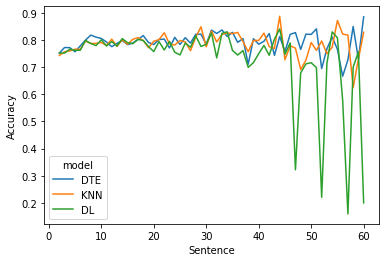

In [32]:
ax = sns.lineplot(data=df_all, x='Sentence', y='Accuracy', hue='model')

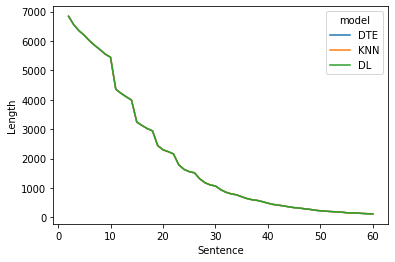

In [33]:
ax = sns.lineplot(data=df_all, x='Sentence', y='Length', hue='model')

Evaluate

In [34]:
df = metrics
grouped = df.groupby(df.group)
df_abiEltern = grouped.get_group("abiEltern")

df_abiEltern = df_abiEltern.drop(columns=['group', 'Accuracy'])
df_abiEltern = pd.pivot_table(df_abiEltern, values=["Precision","Recall","AUC","FPR"], index=["model", "Sentence"], columns=["subgroup"])
df_abiEltern['PP'] = df_abiEltern.Precision.abi-df_abiEltern.Precision.keinAbi
df_abiEltern['EO'] = df_abiEltern.Recall.keinAbi-df_abiEltern.Recall.abi
df_abiEltern['SA'] = df_abiEltern.AUC.abi-df_abiEltern.AUC.keinAbi
df_abiEltern['PE'] = df_abiEltern.FPR.keinAbi-df_abiEltern.FPR.abi
df_abiEltern = df_abiEltern.drop(columns=['AUC','Precision','Recall','FPR'])
df_abiEltern.columns = df_abiEltern.columns.droplevel(1)
df_abiEltern = pd.pivot_table(df_abiEltern, values=["PP","EO","SA","PE"], index=["Sentence"], columns=["model"])



In [35]:
#format result

def threshold001(v, props=''):
    return props if (v > 0.02) or (v < -0.02) else None

def threshold005(v, props=''):
    return props if (v > 0.05) or (v < -0.05) else None

def negativeValue(v, props=''):
    return props if (v < 0) else None

def showTable(df):
    styled = df.style.set_properties(color="black", align="right")\
        .set_properties(**{'background-color': 'white'})\
        .applymap(threshold001, props='color:orange;')\
        .applymap(threshold005, props='color:red;')\
        .applymap(negativeValue, props='font-weight:bold;')
    return styled

In [36]:
test = df_abiEltern
met = ['EO','PE','PP','SA']
fertig = pd.DataFrame()
for x in met:        
    a = 0
    for i in range(2, 10):
        a = a+test[x].DL[i]
    a = a/8
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '02-9',
            'Val': a
        }
    )
    fertig = pd.concat([fertig, temp])

    b = 0
    for i in range(10, 20):
        b = b+test[x].DL[i]
    b = b/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '10-19',
            'Val': b
        }
    )
    fertig = pd.concat([fertig, temp])

    c = 0
    for i in range(20, 30):
        c = c+test[x].DL[i]
    c = c/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '20-29',
            'Val': c
        }
    )
    fertig = pd.concat([fertig, temp])

    d = 0
    for i in range(30, 40):
        d = d+test[x].DL[i]
    d = d/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '30-39',
            'Val': d
        }
    )
    fertig = pd.concat([fertig, temp])

    e = 0
    for i in range(40, 50):
        e = e+test[x].DL[i]
    e = e/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '40-49',
            'Val': e
        }
    )
    fertig = pd.concat([fertig, temp])

    f = 0
    for i in range(50, 60):
        f = f+test[x].DL[i]
    f = f/10
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '50-60',
            'Val': f
        }
    )
    fertig = pd.concat([fertig, temp])

    

met = ['EO','PE','PP','SA']
for x in met:        
    a = 0
    for i in range(2, 10):
        a = a+test[x].DTE[i]
    a = a/8
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '02-9',
            'Val': a
        }
    )
    fertig = pd.concat([fertig, temp])

    b = 0
    for i in range(10, 20):
        b = b+test[x].DTE[i]
    b = b/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '10-19',
            'Val': b
        }
    )
    fertig = pd.concat([fertig, temp])

    c = 0
    for i in range(20, 30):
        c = c+test[x].DTE[i]
    c = c/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '20-29',
            'Val': c
        }
    )
    fertig = pd.concat([fertig, temp])

    d = 0
    for i in range(30, 40):
        d = d+test[x].DTE[i]
    d = d/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '30-39',
            'Val': d
        }
    )
    fertig = pd.concat([fertig, temp])

    e = 0
    for i in range(40, 50):
        e = e+test[x].DTE[i]
    e = e/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '40-49',
            'Val': e
        }
    )
    fertig = pd.concat([fertig, temp])

    f = 0
    for i in range(50, 60):
        f = f+test[x].DTE[i]
    f = f/10
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '50-60',
            'Val': f
        }
    )
    fertig = pd.concat([fertig, temp])

met = ['EO','PE','PP','SA']
for x in met:        
    a = 0
    for i in range(2, 10):
        a = a+test[x].KNN[i]
    a = a/8
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '02-9',
            'Val': a
        }
    )
    fertig = pd.concat([fertig, temp])

    b = 0
    for i in range(10, 20):
        b = b+test[x].KNN[i]
    b = b/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '10-19',
            'Val': b
        }
    )
    fertig = pd.concat([fertig, temp])

    c = 0
    for i in range(20, 30):
        c = c+test[x].KNN[i]
    c = c/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '20-29',
            'Val': c
        }
    )
    fertig = pd.concat([fertig, temp])

    d = 0
    for i in range(30, 40):
        d = d+test[x].KNN[i]
    d = d/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '30-39',
            'Val': d
        }
    )
    fertig = pd.concat([fertig, temp])

    e = 0
    for i in range(40, 50):
        e = e+test[x].KNN[i]
    e = e/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '40-49',
            'Val': e
        }
    )
    fertig = pd.concat([fertig, temp])

    f = 0
    for i in range(50, 60):
        f = f+test[x].KNN[i]
    f = f/10
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '50-60',
            'Val': f
        }
    )
    fertig = pd.concat([fertig, temp])




In [39]:
mean_table = pd.pivot_table(fertig, values=['Val'], index=['Range'], columns=['Metrik','Model'])
showTable(mean_table)

In [38]:
# writer = pd.ExcelWriter('df_abiEltern.xlsx', engine='xlsxwriter')
# df_abiEltern.to_excel(writer, sheet_name='AbiEltern')
# writer.save()